<a href="https://colab.research.google.com/github/danoAasland/medicareEDA/blob/master/medicareEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sodapy

In [0]:
#import packages and set global settings

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.weightstats import ztest
from sodapy import Socrata

#set graphs to plot within env and supress any warnings
%matplotlib inline
warnings.filterwarnings('ignore')
#set style of graphs
sns.set(style="darkgrid", rc={'figure.figsize':(12, 6)})

In [3]:
#connect to data source using socrata
api = 'INSERT API KEY HERE'
client = Socrata('data.medicare.gov', api)
# Retrieve dataset and store results as a dataframe:
df = pd.DataFrame.from_records(client.get('kac9-a9fp', limit=50000))

# Close the connection:
client.close()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19674 entries, 0 to 19673
Data columns (total 12 columns):
hospital_name                 19674 non-null object
provider_id                   19674 non-null object
state                         19674 non-null object
measure_name                  19674 non-null object
number_of_discharges          19674 non-null object
excess_readmission_ratio      19674 non-null object
predicted_readmission_rate    19674 non-null object
expected_readmission_rate     19674 non-null object
number_of_readmissions        19674 non-null object
start_date                    19674 non-null object
end_date                      19674 non-null object
footnote                      8157 non-null object
dtypes: object(12)
memory usage: 1.8+ MB


In [4]:
df.head()

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote
0,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_AMI_HRRP,798,1.0072,14.8575,14.7514,119,07/01/2014,06/30/2017,NaN
1,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_CABG_HRRP,290,1.1392,14.0204,12.3077,44,07/01/2014,06/30/2017,NaN
2,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_COPD_HRRP,569,0.9913,18.2153,18.3745,103,07/01/2014,06/30/2017,NaN
3,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HF_HRRP,1061,1.0135,21.5968,21.3101,230,07/01/2014,06/30/2017,NaN
4,SOUTHEAST ALABAMA MEDICAL CENTER,010001,AL,READM_30_HIP_KNEE_HRRP,335,1.0468,5.0853,4.8582,18,07/01/2014,06/30/2017,NaN


In [5]:
df.start_date.value_counts()

07/01/2014    19674
Name: start_date, dtype: int64

In [6]:
df.end_date.value_counts()

06/30/2017    19674
Name: end_date, dtype: int64

In [7]:
# Top values for 'number_of_discharges': 
df.number_of_discharges.value_counts()[:5]

Not Available    8019
0                 123
107                44
91                 40
89                 39
Name: number_of_discharges, dtype: int64

In [8]:
# Top values for 'readm_ratio': 
df.excess_readmission_ratio.value_counts()[:5]

Not Available    5394
0.9765             17
1.0048             16
0.9799             15
0.9823             15
Name: excess_readmission_ratio, dtype: int64

In [36]:
# Filter out 'Not Available':
df2 = df[(df.number_of_discharges != 'Not Available') & (df.excess_readmission_ratio != 'Not Available')]
df2[['number_of_discharges', 'excess_readmission_ratio']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 19595
Data columns (total 2 columns):
number_of_discharges        11532 non-null object
excess_readmission_ratio    11532 non-null object
dtypes: object(2)
memory usage: 270.3+ KB


In [0]:
# Convert 'number_of_discharges' to int, 'readm_ratio' to float:
df2['number_of_discharges'] = df2['number_of_discharges'].astype(int)
df2['excess_readmission_ratio'] = df2['excess_readmission_ratio'].astype(float)
df2['provider_id'] = df2['provider_id'].astype(int)
df2['predicted_readmission_rate'] = df2['predicted_readmission_rate'].astype(float)
df2['expected_readmission_rate'] = df2['expected_readmission_rate'].astype(float) 
df2['number_of_readmissions'] = df2['number_of_readmissions'].astype(float) 
#df2[['number_of_discharges', 'readm_ratio']].info()

In [38]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 19595
Data columns (total 12 columns):
hospital_name                 11532 non-null object
provider_id                   11532 non-null int64
state                         11532 non-null object
measure_name                  11532 non-null object
number_of_discharges          11532 non-null int64
excess_readmission_ratio      11532 non-null float64
predicted_readmission_rate    11532 non-null float64
expected_readmission_rate     11532 non-null float64
number_of_readmissions        11532 non-null float64
start_date                    11532 non-null object
end_date                      11532 non-null object
footnote                      15 non-null object
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


In [0]:
import statsmodels.api as sm

In [0]:
X = df2[['number_of_discharges', 'number_of_readmissions']]
Y = df2['excess_readmission_ratio']

In [0]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [59]:
print_model = model.summary()
print(print_model)

                               OLS Regression Results                               
Dep. Variable:     excess_readmission_ratio   R-squared:                       0.109
Model:                                  OLS   Adj. R-squared:                  0.109
Method:                       Least Squares   F-statistic:                     704.7
Date:                      Wed, 08 Jan 2020   Prob (F-statistic):          1.79e-289
Time:                              21:35:02   Log-Likelihood:                 12205.
No. Observations:                     11532   AIC:                        -2.440e+04
Df Residuals:                         11529   BIC:                        -2.438e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [11]:
df2.describe()

,number_of_discharges,readm_ratio
count,11532.000000,11532.000000
mean,392.983177,1.007515
std,354.777576,0.088961
min,27.000000,0.598200
25%,162.000000,0.953475
50%,291.000000,1.003150
75%,508.000000,1.055800
max,8931.000000,1.825600


In [0]:
df2.measure_name.replace(to_replace=dict(READM_30_AMI_HRRP = 'AMI', READM_30_CABG_HRRP = 'CABG',
                                         READM_30_HF_HRRP = 'HF', READM_30_HIP_KNEE_HRRP = 'HIP_KNEE',
                                         READM_30_PN_HRRP = 'PNA', READM_30_COPD_HRRP = 'COPD'), inplace = True)

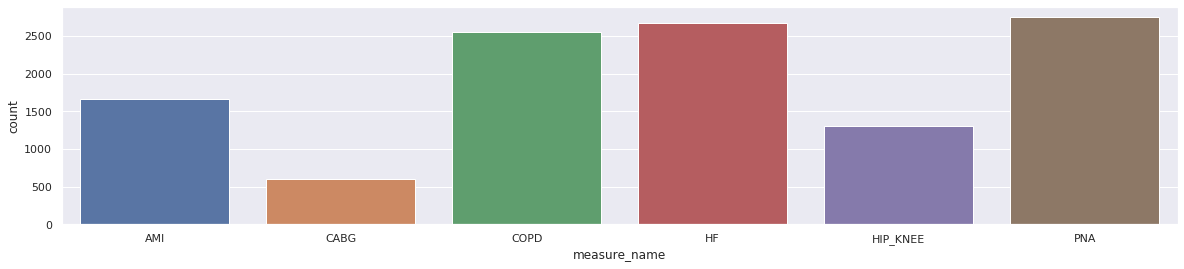

In [15]:

fig, ax = plt.subplots(figsize=(20, 4))
sns.countplot(df2.measure_name);

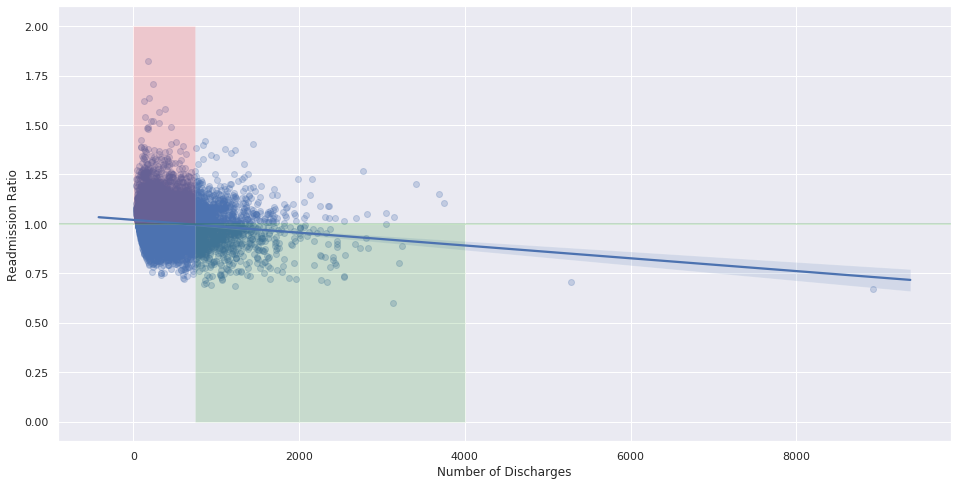

In [67]:
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(df2.number_of_discharges, df2.excess_readmission_ratio, scatter_kws={'alpha':0.25}).axhline(y=1, color='green', linewidth=0.35)

# Shade an area to indicate small, excess readmissions:
plt.fill_between([0, 750], 1, 2, facecolor='red', alpha=0.15)

# Shade an area to indicate larger, acceptable readmissions:
plt.fill_between([750, 4000], 0, 1, facecolor='green', alpha=0.15)

plt.xlabel('Number of Discharges')
plt.ylabel('Readmission Ratio');

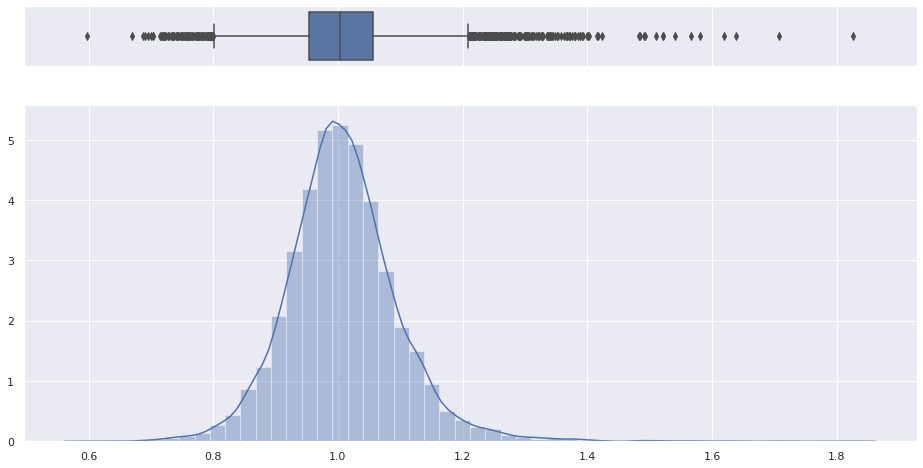

In [68]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df2.excess_readmission_ratio, ax=boxplot)
sns.distplot(df2.excess_readmission_ratio, ax=histogram)
boxplot.set(xlabel='')
#plt.title('Distribution of "Readmit Ratio"', fontsize=24)
plt.xlabel('');

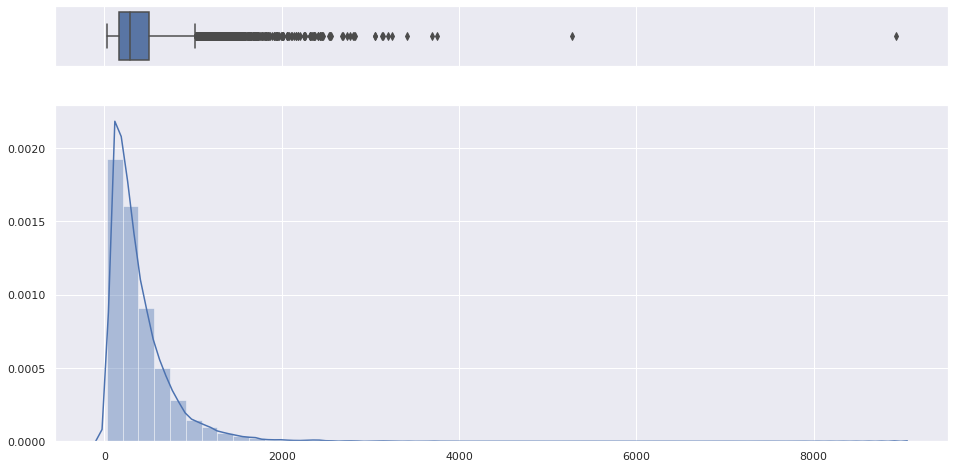

In [69]:
fig, (boxplot, histogram) = plt.subplots(2, sharex=True, figsize=(16, 8), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df2.number_of_discharges, ax=boxplot)
sns.distplot(df2.number_of_discharges, ax=histogram)
boxplot.set(xlabel='')
#plt.title('Distribution of "Number of Discharges"', fontsize=24)
plt.xlabel('');

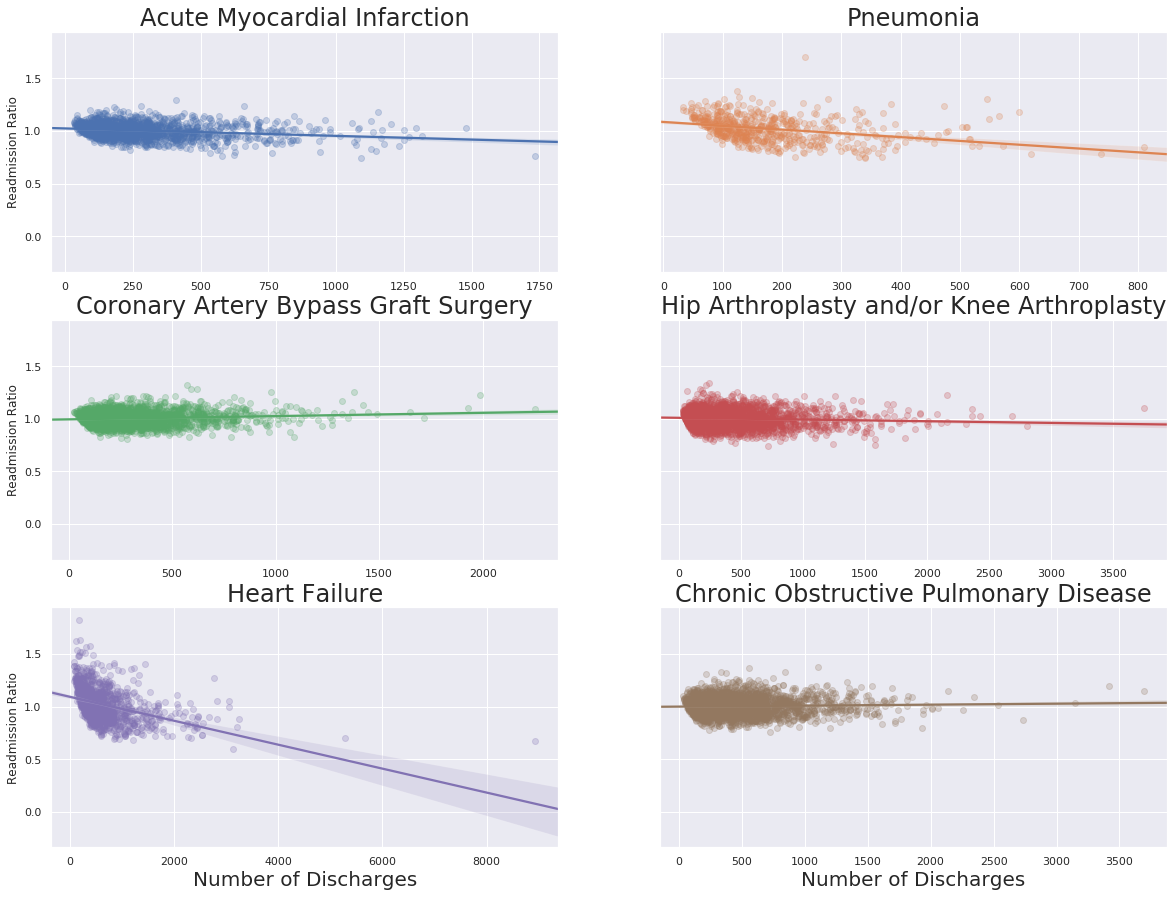

In [70]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, sharey=True, figsize=(20, 15))

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[0]], ax=ax0, scatter_kws={'alpha':0.25})
ax0.set_title('Acute Myocardial Infarction', fontsize=24)
ax0.set_xlabel('')
ax0.set_ylabel('Readmission Ratio')

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[1]], ax=ax1, scatter_kws={'alpha':0.25})
ax1.set_title('Pneumonia', fontsize=24)
ax1.set_xlabel('')
ax1.set_ylabel('')

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[2]], ax=ax2, scatter_kws={'alpha':0.25})
ax2.set_title('Coronary Artery Bypass Graft Surgery', fontsize=24)
ax2.set_xlabel('')
ax2.set_ylabel('Readmission Ratio')

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[3]], ax=ax3, scatter_kws={'alpha':0.25})
ax3.set_title('Hip Arthroplasty and/or Knee Arthroplasty', fontsize=24)
ax3.set_xlabel('')
ax3.set_ylabel('')

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[4]], ax=ax4, scatter_kws={'alpha':0.25})
ax4.set_title('Heart Failure', fontsize=24)
ax4.set_xlabel('Number of Discharges', fontsize=20)
ax4.set_ylabel('Readmission Ratio')

sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[5]], ax=ax5, scatter_kws={'alpha':0.25})
ax5.set_title('Chronic Obstructive Pulmonary Disease', fontsize=24)
ax5.set_xlabel('Number of Discharges', fontsize=20)
ax5.set_ylabel('');

In [72]:
df2.groupby('measure_name').excess_readmission_ratio.agg([np.mean]).sort_values(by='mean')

,mean
measure_name,
HF,1.003496
PNA,1.004801
COPD,1.004936
AMI,1.005694
HIP_KNEE,1.022134
CABG,1.022244


In [73]:
#view the outliers over 4k limit
df2[df2.number_of_discharges > 4000]

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct
8578,NEW ENGLAND BAPTIST HOSPITAL,220088,MA,HIP_KNEE,5276,0.7041,2.6181,3.7182,131.0,07/01/2014,06/30/2017,NaN,0.024829
12106,HOSPITAL FOR SPECIAL SURGERY,330270,NY,HIP_KNEE,8931,0.6697,2.7563,4.1158,238.0,07/01/2014,06/30/2017,NaN,0.026649


In [0]:
df2['dc_vs_admit_pct'] = df2.number_of_readmissions / df2.number_of_discharges

In [75]:
df2.tail(1)

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct
19595,BAYLOR SCOTT & WHITE MEDICAL CENTER - MARBLE F...,670108,TX,PNA,164,0.946,14.165,14.9738,20.0,07/01/2014,06/30/2017,NaN,0.121951


In [76]:
print(df2.groupby(['state', 'measure_name'])['dc_vs_admit_pct'].mean())

state  measure_name
AK     AMI             0.108956
       COPD            0.192034
       HF              0.196730
       HIP_KNEE        0.045653
       PNA             0.126633
                         ...   
WY     AMI             0.133718
       COPD            0.170638
       HF              0.177344
       HIP_KNEE        0.059950
       PNA             0.126065
Name: dc_vs_admit_pct, Length: 303, dtype: float64


In [0]:
#df2[df2['state'] == 'AK']

In [0]:
def stateMeasure(df2, stateAbv):
  df2 = df2[df2['state'] == stateAbv]
  fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, sharey=True, figsize=(20, 15))
  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[0]], ax=ax0, scatter_kws={'alpha':0.25})
  ax0.set_title('Acute Myocardial Infarction', fontsize=24)
  ax0.set_xlabel('')
  ax0.set_ylabel('Readmission Ratio')

  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[1]], ax=ax1, scatter_kws={'alpha':0.25})
  ax1.set_title('Pneumonia', fontsize=24)
  ax1.set_xlabel('')
  ax1.set_ylabel('')

  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[2]], ax=ax2, scatter_kws={'alpha':0.25})
  ax2.set_title('Coronary Artery Bypass Graft Surgery', fontsize=24)
  ax2.set_xlabel('')
  ax2.set_ylabel('Readmission Ratio')

  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[3]], ax=ax3, scatter_kws={'alpha':0.25})
  ax3.set_title('Hip Arthroplasty and/or Knee Arthroplasty', fontsize=24)
  ax3.set_xlabel('')
  ax3.set_ylabel('')

  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[4]], ax=ax4, scatter_kws={'alpha':0.25})
  ax4.set_title('Heart Failure', fontsize=24)
  ax4.set_xlabel('Number of Discharges', fontsize=20)
  ax4.set_ylabel('Readmission Ratio')

  sns.regplot('number_of_discharges', 'excess_readmission_ratio', data=df2[df2.measure_name == df2.measure_name.unique().tolist()[5]], ax=ax5, scatter_kws={'alpha':0.25})
  ax5.set_title('Chronic Obstructive Pulmonary Disease', fontsize=24)
  ax5.set_xlabel('Number of Discharges', fontsize=20)
  ax5.set_ylabel('');

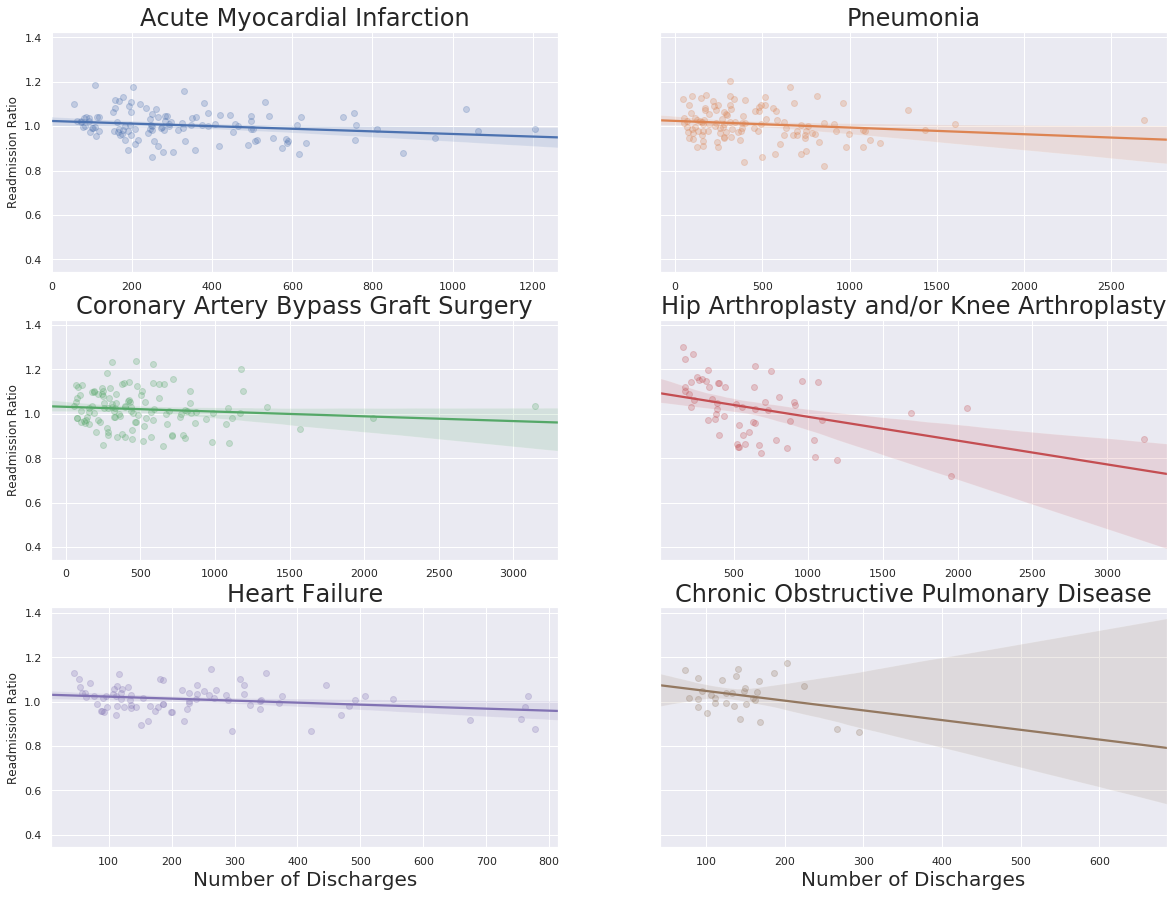

In [78]:
stateMeasure(df2, 'IL')

In [61]:
# Create and save list of columns to convert to float:
float_columns = ['number_of_discharges', 'number_of_readmissions', 'predicted_readmission_rate', 'expected_readmission_rate', 'excess_readmission_ratio']

# Loop through the float_columns list and convert each column from object to float type:
for column in float_columns:
    df2[column] = df2[column].astype(float)
    
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11532 entries, 0 to 11531
Data columns (total 15 columns):
hospital_name                 11532 non-null object
provider_id                   11532 non-null object
state                         11532 non-null object
measure_name                  11532 non-null object
number_of_discharges          11532 non-null float64
excess_readmission_ratio      11532 non-null float64
predicted_readmission_rate    11532 non-null float64
expected_readmission_rate     11532 non-null float64
number_of_readmissions        11532 non-null float64
start_date                    11532 non-null object
end_date                      11532 non-null object
footnote                      15 non-null object
readm_ratio                   11532 non-null float64
service_size                  11532 non-null category
hosp_size                     11532 non-null category
dtypes: category(2), float64(6), object(7)
memory usage: 1.6+ MB


In [123]:
df_hosp = pd.DataFrame({
    'number_of_discharges': df2.groupby('provider_id')['number_of_discharges'].sum(),
    'number_of_readmissions': df2.groupby('provider_id')['number_of_readmissions'].sum(),
    'predicted': df2.groupby('provider_id')['predicted_readmission_rate'].sum(),
    'expected': df2.groupby('provider_id')['expected_readmission_rate'].sum()
})

df_hosp['excess_readmission_ratio'] = df_hosp.predicted / df_hosp.expected
df_hosp['dc_vs_admit_pct'] = df2.number_of_readmissions / df2.number_of_discharges

df_hosp = df_hosp.reset_index(drop=False).rename(columns = {'index':'provider_id'})
df_hosp.head()

,provider_id,number_of_discharges,number_of_readmissions,predicted,expected,excess_readmission_ratio,dc_vs_admit_pct
0,10001,3657,619.0,90.7217,87.8123,1.033132,0.137931
1,10005,2021,305.0,58.9343,60.1348,0.980037,0.123308
2,10006,3335,533.0,88.8558,86.2157,1.030622,0.111111
3,10007,427,79.0,53.4981,50.9161,1.050711,0.162011
4,10011,1604,272.0,83.3949,85.6879,0.973240,0.160714


In [90]:
small_service = df2.number_of_discharges <= 750
large_service = df2.number_of_discharges > 750

small_hospital = df_hosp.number_of_discharges <= 1500
large_hospital = df_hosp.number_of_discharges > 1500

print('Small Service Sample Size:', len(df2[small_service]), 'Large Service Sample Size:', len(df2[large_service]))
print('Small Hospital Sample Size:', len(df_hosp[small_hospital]), 'Large Hospital Sample Size:', len(df_hosp[large_hospital]))

Small Service Sample Size: 10186 Large Service Sample Size: 1346
Small Hospital Sample Size: 1760 Large Hospital Sample Size: 1135


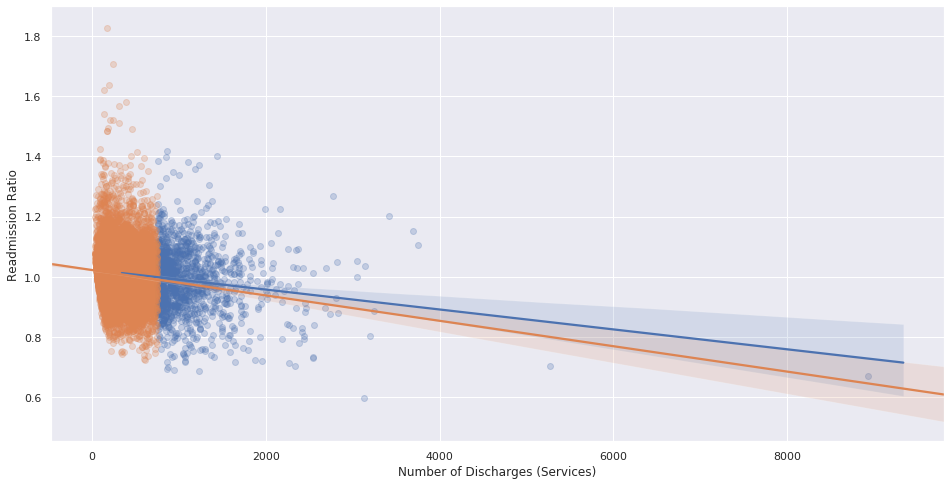

In [91]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(df2[large_service].number_of_discharges, df2[large_service].excess_readmission_ratio, scatter_kws={'alpha':0.25})
sns.regplot(df2[small_service].number_of_discharges, df2[small_service].excess_readmission_ratio, scatter_kws={'alpha':0.25})

plt.xlabel('Number of Discharges (Services)')
plt.ylabel('Readmission Ratio');

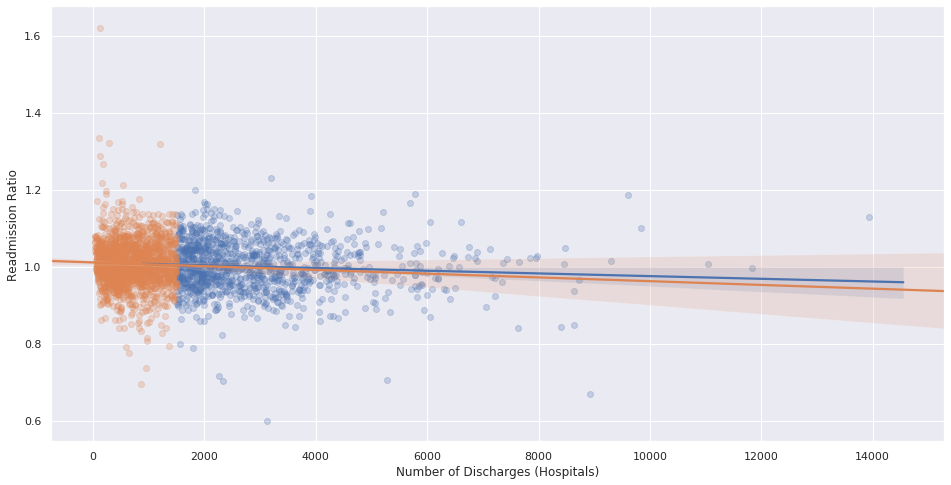

In [92]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(df_hosp[large_hospital].number_of_discharges, df_hosp[large_hospital].excess_readmission_ratio, scatter_kws={'alpha':0.25})
sns.regplot(df_hosp[small_hospital].number_of_discharges, df_hosp[small_hospital].excess_readmission_ratio, scatter_kws={'alpha':0.25})

plt.xlabel('Number of Discharges (Hospitals)')
plt.ylabel('Readmission Ratio');

In [94]:
# Look at hospitals with exceptionally high readmission ratios:
df_hosp[df_hosp.excess_readmission_ratio > 1.2].sort_values('excess_readmission_ratio', ascending=False)

,provider_id,number_of_discharges,number_of_readmissions,predicted,expected,excess_readmission_ratio
1155,190201,132,18.0,6.0652,3.7447,1.619676
2395,440152,114,12.0,5.2998,3.9703,1.334861
2253,390327,285,21.0,5.3515,4.0517,1.320804
1066,180050,1204,365.0,77.3653,58.7224,1.317475
1659,320017,131,12.0,5.1190,3.9742,1.288058
2862,670005,185,15.0,5.4479,4.3031,1.266041
626,100260,3193,600.0,97.7293,79.4618,1.229890
2858,530015,160,11.0,4.3538,3.5746,1.217982
118,30112,543,29.0,4.6162,3.8116,1.211092


In [95]:
# Find all records for hospitals with exceptionally high readmission ratios:
df2[df2.provider_id.isin(df_hosp[df_hosp.excess_readmission_ratio > 1.2].provider_id.tolist())].sort_values(['provider_id', 'excess_readmission_ratio'])

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct
832,ARIZONA SPECIALTY HOSPITAL,30112,AZ,HIP_KNEE,543,1.2111,4.6162,3.8116,29.0,07/01/2014,06/30/2017,NaN,0.053407
4308,ST LUCIE MEDICAL CENTER,100260,FL,AMI,176,1.1498,19.3517,16.8310,43.0,07/01/2014,06/30/2017,NaN,0.244318
4310,ST LUCIE MEDICAL CENTER,100260,FL,COPD,636,1.1694,22.7751,19.4762,157.0,07/01/2014,06/30/2017,NaN,0.246855
4311,ST LUCIE MEDICAL CENTER,100260,FL,HF,595,1.2113,26.5818,21.9440,171.0,07/01/2014,06/30/2017,NaN,0.287395
4313,ST LUCIE MEDICAL CENTER,100260,FL,PNA,559,1.3672,22.9595,16.7931,148.0,07/01/2014,06/30/2017,NaN,0.264758
4312,ST LUCIE MEDICAL CENTER,100260,FL,HIP_KNEE,1227,1.3721,6.0612,4.4175,81.0,07/01/2014,06/30/2017,NaN,0.066015
7232,HARLAN ARH HOSPITAL,180050,KY,COPD,622,1.2845,25.6081,19.9355,179.0,07/01/2014,06/30/2017,NaN,0.287781
7235,HARLAN ARH HOSPITAL,180050,KY,PNA,335,1.3284,23.3095,17.5475,96.0,07/01/2014,06/30/2017,NaN,0.286567
7233,HARLAN ARH HOSPITAL,180050,KY,HF,247,1.3394,28.4477,21.2394,90.0,07/01/2014,06/30/2017,NaN,0.364372
7798,CHRISTUS LAKE AREA HOSPITAL,190201,LA,HIP_KNEE,132,1.6197,6.0652,3.7447,18.0,07/01/2014,06/30/2017,NaN,0.136364


In [119]:
# Find all records for hospitals with exceptionally low readmission ratios:
df2[df2.provider_id.isin(df_hosp[df_hosp.excess_readmission_ratio < 0.85].provider_id.tolist())].sort_values(['provider_id', 'excess_readmission_ratio'])

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct,service_size,hosp_size
450,"CORE INSTITUTE SPECIALTY HOSPITAL, THE",30108,AZ,HIP_KNEE,468,0.8393,3.1106,3.7061,11.0,07/01/2014,06/30/2017,NaN,0.023504,small,small
656,ARKANSAS SURGICAL HOSPITAL,40147,AR,HIP_KNEE,2265,0.7152,2.6840,3.7527,54.0,07/01/2014,06/30/2017,NaN,0.023841,large,large
1590,HOAG ORTHOPEDIC INSTITUTE,50769,CA,HIP_KNEE,3130,0.5982,2.3782,3.9755,64.0,07/01/2014,06/30/2017,NaN,0.020447,large,large
1976,NAPLES COMMUNITY HOSPITAL,100018,FL,HIP_KNEE,2443,0.7939,3.5512,4.4733,82.0,07/01/2014,06/30/2017,NaN,0.033565,large,large
1972,NAPLES COMMUNITY HOSPITAL,100018,FL,AMI,942,0.7991,12.1527,15.2074,101.0,07/01/2014,06/30/2017,NaN,0.107219,large,large
1977,NAPLES COMMUNITY HOSPITAL,100018,FL,PNA,1933,0.8009,12.7713,15.9466,234.0,07/01/2014,06/30/2017,NaN,0.121055,large,large
1974,NAPLES COMMUNITY HOSPITAL,100018,FL,COPD,1071,0.8724,16.2476,18.6246,164.0,07/01/2014,06/30/2017,NaN,0.153128,large,large
1973,NAPLES COMMUNITY HOSPITAL,100018,FL,CABG,337,0.8735,10.4965,12.0163,32.0,07/01/2014,06/30/2017,NaN,0.094955,small,large
1975,NAPLES COMMUNITY HOSPITAL,100018,FL,HF,1908,0.8991,19.0620,21.2016,357.0,07/01/2014,06/30/2017,NaN,0.187107,large,large
2187,SARASOTA MEMORIAL HOSPITAL,100087,FL,HIP_KNEE,2544,0.7351,3.1581,4.2961,74.0,07/01/2014,06/30/2017,NaN,0.029088,large,large


In [120]:
df2.dc_vs_admit_pct.describe()

count    11532.000000
mean         0.169542
std          0.061656
min          0.018003
25%          0.139073
50%          0.175364
75%          0.209402
max          0.500000
Name: dc_vs_admit_pct, dtype: float64

In [126]:
# Find all records for hospitals with exceptionally high readmission percentage:
df2[df2.provider_id.isin(df_hosp[df_hosp.dc_vs_admit_pct > 0.209].provider_id.tolist())].sort_values(['dc_vs_admit_pct'], ascending=False)

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct,service_size,hosp_size
155,UNIVERSITY OF SOUTH ALABAMA MEDICAL CENTER,10087,AL,COPD,27,1.0637,22.9022,21.5317,11.0,07/01/2014,06/30/2017,NaN,0.407407,small,small
97,RIVERVIEW REGIONAL MEDICAL CENTER,10046,AL,HF,426,1.2158,28.3109,23.2865,134.0,07/01/2014,06/30/2017,NaN,0.314554,small,small
145,SOUTH BALDWIN REGIONAL MEDICAL CENTER,10083,AL,HF,366,1.1722,25.0271,21.3506,102.0,07/01/2014,06/30/2017,NaN,0.278689,small,small
95,RIVERVIEW REGIONAL MEDICAL CENTER,10046,AL,CABG,47,1.1875,17.8898,15.0654,13.0,07/01/2014,06/30/2017,NaN,0.276596,small,small
200,BRYAN W. WHITFIELD MEMORIAL HOSPITAL,10112,AL,HF,66,1.0383,20.6578,19.8960,16.0,07/01/2014,06/30/2017,NaN,0.242424,small,small
96,RIVERVIEW REGIONAL MEDICAL CENTER,10046,AL,COPD,337,1.1110,21.3626,19.2281,80.0,07/01/2014,06/30/2017,NaN,0.237389,small,small
26,DEKALB REGIONAL MEDICAL CENTER,10012,AL,HF,156,1.0578,20.8006,19.6646,36.0,07/01/2014,06/30/2017,NaN,0.230769,small,small
33,HELEN KELLER MEMORIAL HOSPITAL,10019,AL,HF,372,1.0618,21.8192,20.5496,85.0,07/01/2014,06/30/2017,NaN,0.228495,small,large
67,CULLMAN REGIONAL MEDICAL CENTER,10035,AL,HF,661,1.0834,21.6177,19.9527,148.0,07/01/2014,06/30/2017,NaN,0.223903,small,large
179,THOMAS HOSPITAL,10100,AL,HF,330,1.0338,21.4779,20.7763,73.0,07/01/2014,06/30/2017,NaN,0.221212,small,large


In [129]:
# Find all records for hospitals with exceptionally low readmission percentage:
df2[df2.provider_id.isin(df_hosp[df_hosp.dc_vs_admit_pct < 0.13].provider_id.tolist())].sort_values(['dc_vs_admit_pct'], ascending=True)

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct,service_size,hosp_size
261,JACK HUGHSTON MEMORIAL HOSPITAL,10168,AL,HIP_KNEE,1351,0.9801,3.8056,3.8830,51.0,07/01/2014,06/30/2017,NaN,0.037750,large,small
189,PRINCETON BAPTIST MEDICAL CENTER,10103,AL,HIP_KNEE,260,0.9840,4.3596,4.4306,11.0,07/01/2014,06/30/2017,NaN,0.042308,small,large
242,SPRINGHILL MEMORIAL HOSPITAL,10144,AL,HIP_KNEE,259,0.9958,4.2810,4.2991,11.0,07/01/2014,06/30/2017,NaN,0.042471,small,large
8,MARSHALL MEDICAL CENTER SOUTH,10005,AL,HIP_KNEE,284,1.0913,5.3414,4.8946,17.0,07/01/2014,06/30/2017,NaN,0.059859,small,large
14,ELIZA COFFEE MEMORIAL HOSPITAL,10006,AL,HIP_KNEE,431,1.3032,5.6779,4.3570,30.0,07/01/2014,06/30/2017,NaN,0.069606,small,large
131,MEDICAL CENTER BARBOUR,10069,AL,PNA,107,0.9567,13.5794,14.1946,12.0,07/01/2014,06/30/2017,NaN,0.112150,small,small
258,COOSA VALLEY MEDICAL CENTER,10164,AL,COPD,132,0.9248,15.6645,16.9391,15.0,07/01/2014,06/30/2017,NaN,0.113636,small,small
211,VAUGHAN REGIONAL MEDICAL CENTER PARKWAY CAMPUS,10118,AL,COPD,163,0.8951,16.6639,18.6162,19.0,07/01/2014,06/30/2017,NaN,0.116564,small,small
239,SPRINGHILL MEMORIAL HOSPITAL,10144,AL,AMI,153,0.9858,13.6323,13.8281,20.0,07/01/2014,06/30/2017,NaN,0.130719,small,large
260,COOSA VALLEY MEDICAL CENTER,10164,AL,PNA,275,0.9584,13.9876,14.5942,36.0,07/01/2014,06/30/2017,NaN,0.130909,small,small


In [96]:
df2['service_size'] = pd.cut(df2['number_of_discharges'], [0, 751, df2.number_of_discharges.max()], labels=['small', 'large'])
df_hosp['hosp_size'] = pd.cut(df_hosp['number_of_discharges'], [0, 1501, df_hosp.number_of_discharges.max()], labels=['small', 'large'])

df2 = pd.merge(df2, df_hosp[['provider_id', 'hosp_size']], on='provider_id', how='inner')
df2.head()

,hospital_name,provider_id,state,measure_name,number_of_discharges,excess_readmission_ratio,predicted_readmission_rate,expected_readmission_rate,number_of_readmissions,start_date,end_date,footnote,dc_vs_admit_pct,service_size,hosp_size
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,AMI,798,1.0072,14.8575,14.7514,119.0,07/01/2014,06/30/2017,NaN,0.149123,large,large
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,CABG,290,1.1392,14.0204,12.3077,44.0,07/01/2014,06/30/2017,NaN,0.151724,small,large
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,COPD,569,0.9913,18.2153,18.3745,103.0,07/01/2014,06/30/2017,NaN,0.181019,small,large
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,HF,1061,1.0135,21.5968,21.3101,230.0,07/01/2014,06/30/2017,NaN,0.216777,large,large
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,HIP_KNEE,335,1.0468,5.0853,4.8582,18.0,07/01/2014,06/30/2017,NaN,0.053731,small,large


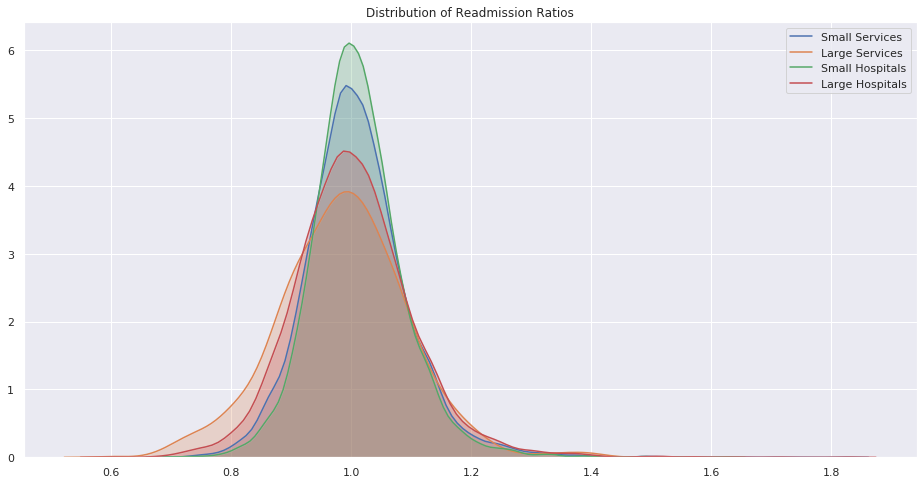

In [98]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.kdeplot(df2[df2.service_size == 'small'].excess_readmission_ratio, shade=True, label='Small Services')
sns.kdeplot(df2[df2.service_size == 'large'].excess_readmission_ratio, shade=True, label='Large Services')
sns.kdeplot(df2[df2.hosp_size == 'small'].excess_readmission_ratio, shade=True, label='Small Hospitals')
sns.kdeplot(df2[df2.hosp_size == 'large'].excess_readmission_ratio, shade=True, label='Large Hospitals')
plt.title('Distribution of Readmission Ratios');

Text(0, 0.5, 'Readmission Ratio')

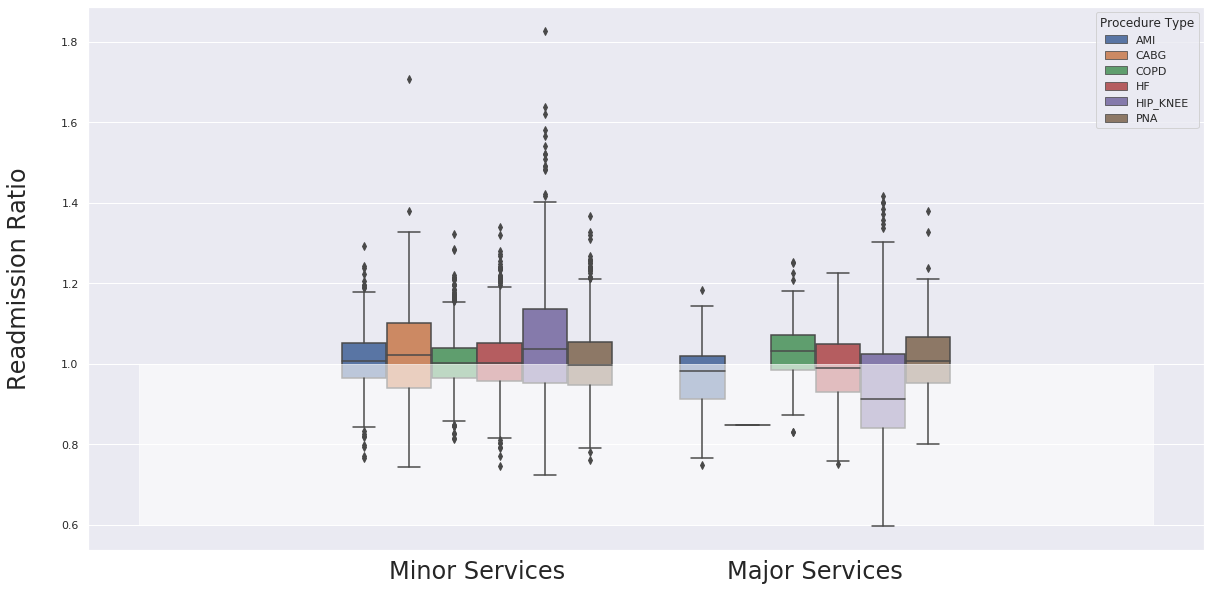

In [112]:
fig, ax = plt.subplots(figsize=(20, 10))

# plot and legend:
sns.boxplot(x='service_size', y='excess_readmission_ratio', hue='measure_name', data=df2)
plt.fill_between([-1, 2], 1, 0.6, facecolor='white', alpha=0.60)
ax.legend(title='Procedure Type')
ax.xaxis.label.set_visible(False)
ax.set_xticklabels(labels=['Minor Services', 'Major Services'])
ax.tick_params(axis='x', which='major', labelsize=24)
ax.set_ylabel('Readmission Ratio', fontsize=24, labelpad=30)

In [101]:
df2[df2.service_size == 'large'].measure_name.value_counts()

PNA         434
HF          368
HIP_KNEE    337
COPD        127
AMI          74
CABG          1
Name: measure_name, dtype: int64

In [113]:
df2[df2.service_size == 'small'].measure_name.value_counts()

COPD        2424
PNA         2314
HF          2302
AMI         1592
HIP_KNEE     964
CABG         595
Name: measure_name, dtype: int64

Text(0, 0.5, 'Readmission Ratio')

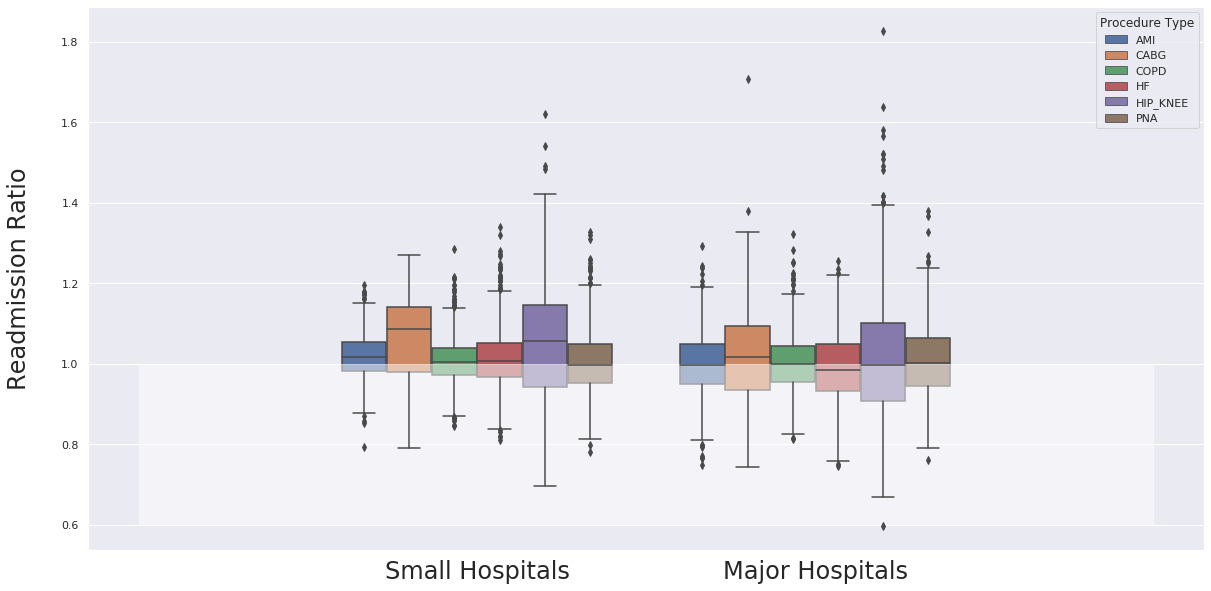

In [114]:
fig, ax = plt.subplots(figsize=(20, 10))

# plot and legend:
sns.boxplot(x='hosp_size', y='excess_readmission_ratio', hue='measure_name', data=df2)
plt.fill_between([-1, 2], 1, 0.6, facecolor='white', alpha=0.50)
ax.legend(title='Procedure Type')
ax.xaxis.label.set_visible(False)
ax.set_xticklabels(labels=['Small Hospitals', 'Major Hospitals'])
ax.tick_params(axis='x', which='major', labelsize=24)
ax.set_ylabel('Readmission Ratio', fontsize=24, labelpad=30)

In [111]:
df2[df2.hosp_size == 'small'].measure_name.value_counts()

PNA         1627
HF          1549
COPD        1435
AMI          592
HIP_KNEE     332
CABG          57
Name: measure_name, dtype: int64

In [115]:
df2[df2.hosp_size == 'large'].measure_name.value_counts()

PNA         1121
HF          1121
COPD        1116
AMI         1074
HIP_KNEE     969
CABG         539
Name: measure_name, dtype: int64